The paper investigates the cause of batch norm's benefits experimentally. The authors show that its main benefit is allowing for larger learning rates during training. In particular: 

>"We show that the activations
and gradients in deep neural networks without BN tend to be heavy-tailed. In particular, during an
early on-set of divergence, a small subset of activations (typically in deep layer) “explode”. The
typical practice to avoid such divergence is to set the learning rate to be sufficiently small such that
no steep gradient direction can lead to divergence. However, small learning rates yield little progress
along flat directions of the optimization landscape and may be more prone to convergence to sharp
local minima with possibly worse generalization performance."

We attempt to reproduce figures 1-3, 5, and 6.

### Convolutional BN Layer

As a reminder, the input $I$ and output $O$ tensors to a batch norm layer are 4 dimensional. The dimensions $(b, c, x, y)$ correspond to the batch example, channel, and spatial $x$, $y$ dimensions respectively. Batch norm (BN) applies a channel-wise normalization:

$$
O_{b, c, x, y} \leftarrow \gamma_c \frac{I_{b, c, x, y} - \hat \mu_c}{\sqrt{\hat \sigma_c^2 + \epsilon}} + \beta_c
$$

Where $\hat \mu_c$ and $\hat \sigma_c^2$ are estimates channel $c$'s mean and standard deviation computed on the minibatch $\mathcal B$:

$$
\hat \mu_c = \frac{1}{|\mathcal B|}\sum_{b, x, y} I_{b, c, x, y}
$$

$$
\hat \sigma_c^2 = \frac{1}{\mathcal |B|} \sum_{b, x, y} (I_{b, c, x, y} - \hat \mu_c) ^ 2
$$

To make sure the layer does not lose expressive power we introduce learned parameters $\gamma_c$ and $\beta_c$. $\epsilon$ is a small constant added for numerical stability. In pytorch, we can simply use the `BatchNorm2d` layer. 

### Experimental setup

Let's set up our data loaders, model, and training loop as described in Appendix B of the paper.

In [1]:
#| code-summary: Imports and model evaluation function
#| output: false

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, itertools, time

os.makedirs('logs', exist_ok = True)
os.makedirs('models', exist_ok = True)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device(
    'cuda' if torch.cuda.is_available() else
    ('mps' if torch.backends.mps.is_available() else
    'cpu')
)

def eval_model(model, test, criterion = nn.CrossEntropyLoss()):
    model.eval()
    correct, loss = 0, 0.0
    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            _, pred = torch.max(model(images), 1)
            correct += (pred == labels).float().sum().item()
            loss += criterion(model(images), labels).item()
    return loss / len(test.dataset), correct / len(test.dataset)

device

device(type='mps')

The paper trains ResNet-110s on CIFAR-10, with channel-wise normalization, random horizontal flipping, and 32-by-32 cropping with 4-pixel zero padding. We'll train the ResNet-101 included in torchvision but keep everything the same. 

We first get the datasets and compute the channel-wise means and variances. Note: both the training and validation set have the same values.

In [3]:
#| code-summary: Datasets and channel-wise means and stds
#| output: false
train_set = datasets.CIFAR10('./data', download = True, train = True, transform = transforms.ToTensor())
val_set = datasets.CIFAR10('./data', download = True, train = False, transform = transforms.ToTensor())

def channel_means_stds(dataset):
    imgs = torch.stack([img for img, _ in train_set])
    return imgs.mean(dim = [0, 2, 3]), imgs.std(dim = [0, 2, 3])

means, stds = channel_means_stds(train_set)
print(f'Training channel-wise\n\tmeans: {means}\n\tstds: {stds}')

means, stds = channel_means_stds(val_set)
print(f'Validation channel-wise\n\tmeans: {means}\n\tstds: {stds}')

Files already downloaded and verified
Files already downloaded and verified
Training channel-wise
	means: tensor([0.4914, 0.4822, 0.4465])
	stds: tensor([0.2470, 0.2435, 0.2616])
Validation channel-wise
	means: tensor([0.4914, 0.4822, 0.4465])
	stds: tensor([0.2470, 0.2435, 0.2616])


We now define the transforms with data augmentation and data loaders with batch size $128$.

In [4]:
#| output: false
#| code-summary: Data transforms and data loaders

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

# We do not perform data augmentation on the validation set
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

train_set.transform = train_transform
val_set.transform = val_transform

train_loader = DataLoader(train_set, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 128, shuffle = False)

We'll use `torchvision`'s implementation of ResNet-101, Xavier initialization, SGD with momentum $0.9$ and
weight decay $5\times 10^{-4}$, and cross-entropy loss. We try to implement the training details and learning rate scheduling as mentioned in the paper:

>"Initially, all models are trained for 165 epochs and as in [17]
we divide the learning rate by 10 after epoch 50% and 75%, at which point learning has typically
plateued. If learning doesn’t plateu for some number of epochs, we roughly double the number of
epochs until it does".

In [9]:
#| code-summary: Init, and train functions
#| output: false

def xavier_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def train_epoch(model, train, optimizer, criterion):
    # Trains the model for one epoch
    model.train()
    train_loss, correct = 0.0, 0
    for images, labels in train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, pred = torch.max(output, 1)
        correct += (pred == labels).float().sum().item()
    return train_loss / len(train.dataset), correct / len(train.dataset)


def train(model, train, val, init_lr, plateau_patience = 20):

    optimizer = optim.SGD(model.parameters(), lr = init_lr, momentum = 0.9, weight_decay = 5e-4)
    scheduler  = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [82, 123], gamma = 0.1)
    criterion = nn.CrossEntropyLoss()

    model.to(device)

    init_epochs = 165

    epoch = 0
    plateau_count = 0
    best_loss = None

    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    while epoch < init_epochs and plateau_count < plateau_patience:

        # Train the model for an epoch
        loss, acc = train_epoch(model, train, optimizer, criterion)
        train_losses.append(loss)
        train_accs.append(acc)

        # Evaluate the model on the validation set
        val_loss, val_acc = eval_model(model, val, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update the learning rate
        scheduler.step(val_loss)

        # Check for a plateau
        if best_loss is None or val_loss < best_loss:
            best_loss = val_loss
            plateau_count = 0
        else:
            plateau_count += 1
        
        epoch += 1

        # "If learning doesn’t plateu for some number of epochs,
        # we roughly double the number of epochs until it does."
        if epoch == init_epochs and plateau_count < plateau_patience:
            init_epochs *= 2

        print(f'Epoch {epoch}/{init_epochs} | Learning Rate: {optimizer.param_groups[0]["lr"]} | '
              f'Training loss: {train_losses[-1]:.4f} | '
              f'Validation loss: {val_losses[-1]:.4f} | '
              f'Validation accuracy: {val_accs[-1]:.4f}')
        
    return train_losses, train_accs, val_losses, val_accs

And we define a function to disable batch norm layers in a model by replacing them with identity layers:

In [6]:
#|code-fold: false
#|code-summary: Function to disable batch normalization
def disable_bn(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            setattr(model, name, nn.Identity())
        else:
            disable_bn(module)  # Recursively replace in child modules

### Fig 1

Figure 1 aims to demonstrate that batch norm's primary benefit is that it allows training with larger learning rates. 

The authors find the highest (*initial*) learning rate with which they can train an unnormalized model ($\alpha = 0.0001$) and compare its performance with normalized models trained with $\alpha \in \{0.0001, 0.003, 0.1\}$.  We train each model once (instead of five times to save on compute) and present train and test accuracy curves. 

In [7]:
#| code-summary: Train models
#| output: false

MODELS_DIR = 'models'
LOGS_DIR = 'logs'

for lr, bn in [(0.0001, False), (0.0001, True), (0.003, True), (0.1, True)]:

    s = f'lr={lr}' + ('_bn' if bn else '')
    print(s)

    model = models.resnet101(num_classes = 10)
    model.apply(xavier_init)

    if not bn: disable_bn(model)

    torch.save(model, f'{MODELS_DIR}/{s}_init.pth')
    data = train(model, train_loader, val_loader, init_lr = lr)
    torch.save(model, f'{MODELS_DIR}/{s}_end.pth')
    torch.save(data, f'{LOGS_DIR}/{s}.pth')

lr=0.1_bn took 83 epochs
lr=0.0001 took 263 epochs
lr=0.003_bn took 69 epochs
lr=0.0001_bn took 211 epochs


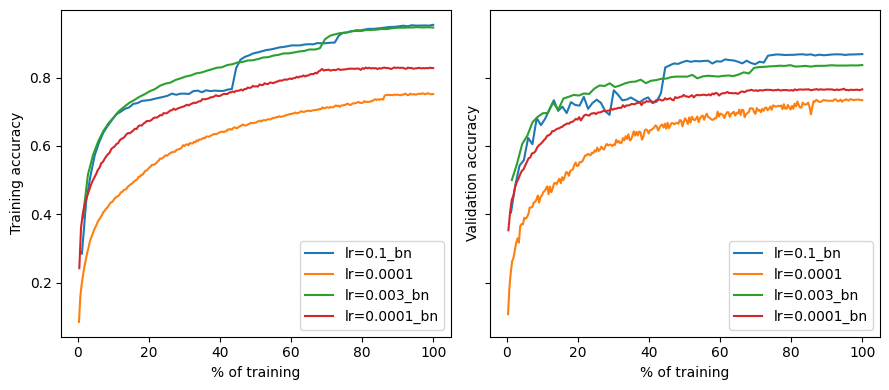

In [108]:
# code-summary: Plot results

get_x = lambda x: 100 * np.arange(1, len(x) + 1) / len(x)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4), sharey = True)

for fname in os.listdir(LOGS_DIR):

    train_losses, train_accs, val_losses, val_accs = torch.load(f'{LOGS_DIR}/{fname}')
    ax1.plot(get_x(train_accs), train_accs, label = fname[:-4])
    ax2.plot(get_x(val_accs), val_accs, label = fname[:-4])
    print(f'{fname[:-4]} took {len(train_accs)} epochs')


ax1.legend(); ax2.legend()
ax1.set_ylabel('Training accuracy'); ax2.set_ylabel('Validation accuracy')
ax1.set_xlabel('% of training'); ax2.set_xlabel('% of training')
f.tight_layout()

And observe the same general trends found in the original paper: similar learning rates result in about the same performance (red and orange) while increasing the rate yields better performance for normalized networks (blue) and training diverges for non-normalized ones (not shown).

### Fig 2

In Figure 2 the authors begin to investigate *"why BN facilitates training with higher learning rates in the first place"*. The authors claim that batch norm (BN) prevents divergence during training, which usually occurs because of large gradients in the first mini-batches.

So, the authors analyze the gradients at initialization of a midpoint layer (55) with and without batch norm. They find that gradients in unnormalized networks are consistently larger and distributed with heavier tails. 

I had trouble replicating this figure. I could not obtain the general shape and scale of the histograms they did:

![](images/fig2.png){width=500 fig-align="center"}

At first, I thought because I was

- looking at the wrong layer, +- 1 (then found it made little difference)
- logging the gradient magnitudes incorrectly - why does the plot have negative values? (then found the authors plot the raw gradient)
- misunderstanding the whole process

As I understood it, we initialize the model (using Xavier's initialization), do a forward and backward pass on a single batch, and log the gradients at roughly the middle layer:

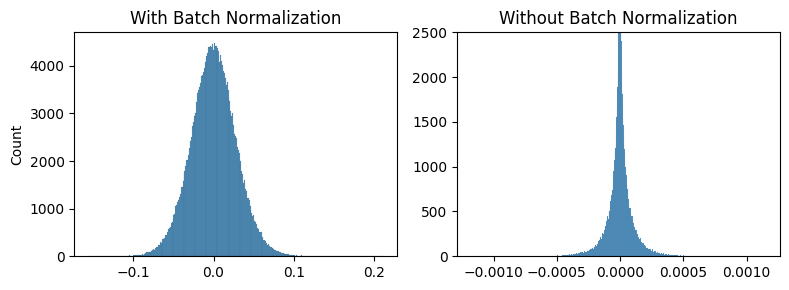

In [10]:
#| code-fold: false

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3))
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

for bn, ax in zip([True, False], [ax1, ax2]):

    # Init
    model = models.resnet101(num_classes = 10)
    model.to(device)
    if not bn: disable_bn(model)
    model.apply(xavier_init)

    # Forward and backward pass
    model.train()
    output = model(images)
    loss = nn.CrossEntropyLoss()(output, labels)
    loss.backward()

    model.eval()
    grads = model.layer3[9].conv1.weight.grad.view(-1).cpu().detach().numpy()
    sns.histplot(grads, ax = ax)

ax1.set_title('With Batch Normalization')
ax2.set_title('Without Batch Normalization')
ax2.set_ylim((0, 2500)); ax2.set_ylabel('')
f.tight_layout()

Although the unnormalized gradients are heavy-tailed, they are still much smaller than the normalized ones. I was stuck on this issue for a few days until I experimented with different initializations:

In [24]:
#| code-summary: Trying other inits
#| output: false

def init_func(f, also_linear = True):
    def init(m):
        if isinstance(m, nn.Conv2d):
            f(m.weight)
        if also_linear and isinstance(m, nn.Linear):
            f(m.weight)
    return init

criterion = nn.CrossEntropyLoss()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with_bn, without_bn = {}, {}

for init_f in [
    nn.init.xavier_uniform_, nn.init.kaiming_uniform_,
    nn.init.kaiming_normal_, lambda x: nn.init.kaiming_normal_(x, mode = 'fan_out', nonlinearity='relu')]:

    init_name = init_f.__name__[:-1]
    if 'lambda' in init_name: init_name = '(default) kaiming_normal fan_out'
    
    for linear in (True, False):

        lin_name = ' w/linear lyrs' if linear else ''
        
        for bn, d in zip((True, False), (with_bn, without_bn)):
                
                model = models.resnet101(num_classes = 10)
                model.to(device)
                if not bn: disable_bn(model)
                model.apply(init_func(init_f, linear))

                model.train()
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()

                model.eval()
                d[init_name + lin_name] = model.layer3[9].conv1.weight.grad.view(-1).cpu().detach().numpy()

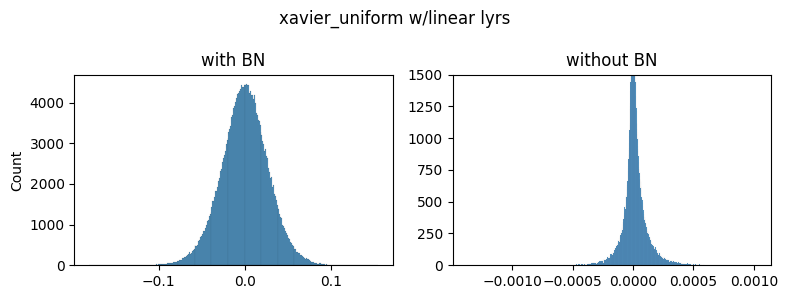

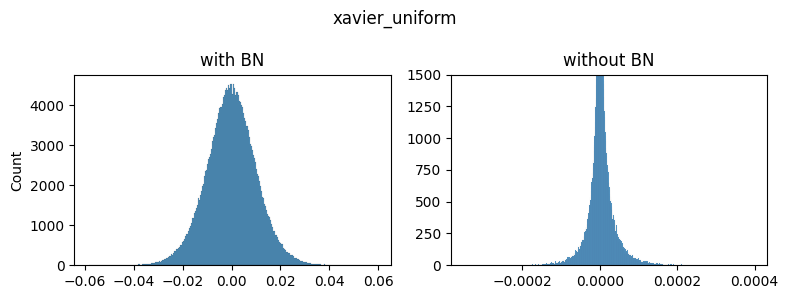

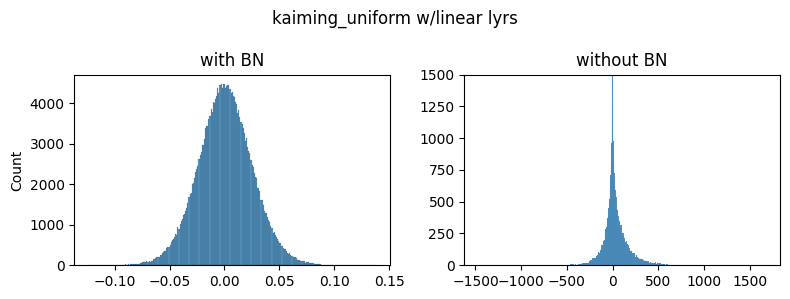

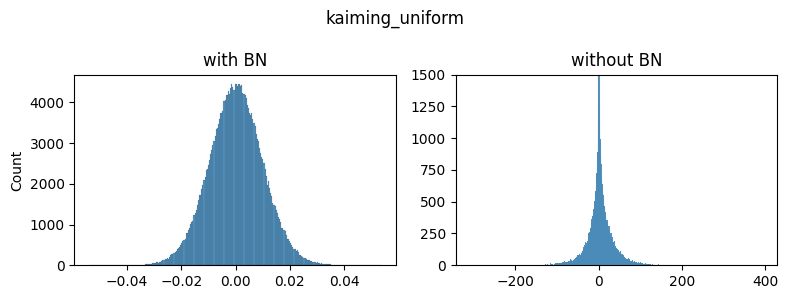

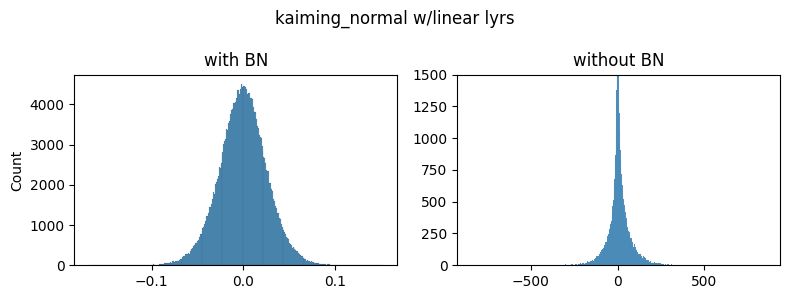

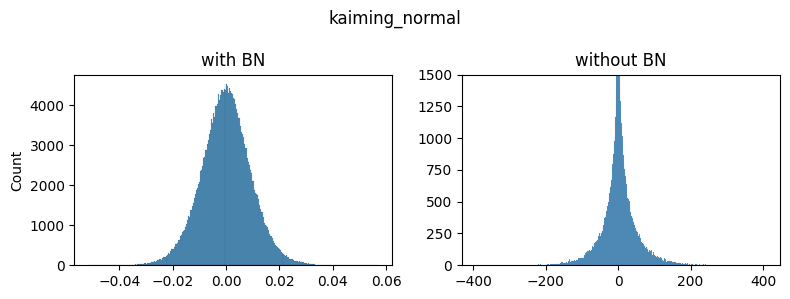

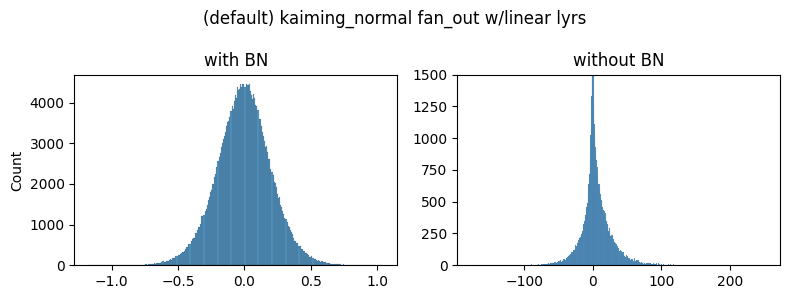

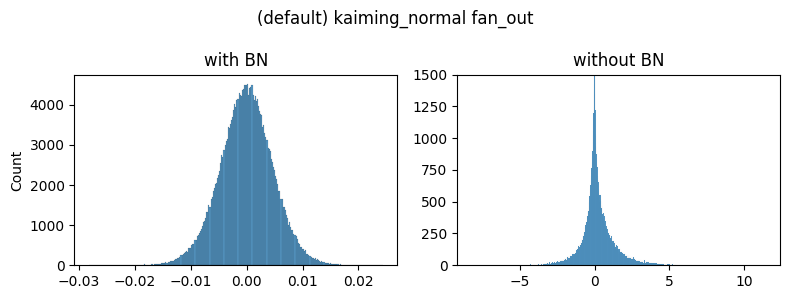

In [25]:
#| code-summary: Plotting the results
for init_name, v in with_bn.items():
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3))
    sns.histplot(v, ax = ax1)
    ax1.set_title('with BN')
    sns.histplot(without_bn[init_name], ax = ax2)
    ax2.set_title('without BN')
    ax2.set_ylabel('')
    ax2.set_ylim(0, 1500)
    f.suptitle(init_name)
    f.tight_layout()

As you can see the general shapes, normal vs heavy-tailed don't depend that much on the initialization scheme but the scales do. We could only achieve the same scale of the gradients presented in the paper by using the `kaiming_normal` scheme with `fan=out` (to preserve the magnitudes of the variance of the weights in the backward pass instead of the forward one) and applying it only to `Conv2` layers. This is the default used by torchvision's resnets. 

Note: `xavier_normal` produced very similar shapes/scales as `xavier_uniform` so we don't show it. 

For the rest of the figures we'll use the default init scheme:

In [26]:
#| code-fold: false
def init_net(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode = 'fan_out', nonlinearity = 'relu')

### Fig 3

The authors then investigate the loss landscape along the gradient direction for the first few mini-batches for models with BN (trained with $\alpha = 0.1$) and without BN ($\alpha = 0.0001$). For each network and mini-batch they compute the gradient and plot the relative change in the loss (new_loss/old_loss).

We save the model's and optimizer's states (`state_dict`) before taking the tentative steps to explore the landscape and restore them before taking the actual step between batches.

In [57]:
#| code-summary: Explore loss landscape
#| output: false

def fig3(model, init_lr, log_lrs, log_batches = [1, 4, 7]):

    # batch -> list of relative losses for each lr
    out = {}

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = init_lr, momentum = 0.9, weight_decay = 5e-4)

    for i, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)

        if i in log_batches:
            
            torch.save(model.state_dict(), f'models/model_state.tmp')
            torch.save(optimizer.state_dict(), f'models/optimizer_state.tmp')

            rel_losses = []
            for lr in log_lrs:

                for param_group in optimizer.param_groups: param_group['lr'] = lr

                optimizer.zero_grad()
                output = model(images)
                current_loss = criterion(output, labels)
                current_loss.backward()
                optimizer.step()

                with torch.no_grad():
                    output = model(images)
                    tmp_loss = criterion(output, labels)
                    rel_loss = (tmp_loss / current_loss).item()
                
                    # print learning rate, current loss, tmp loss, relative loss (at 4 decimal places)
                    print(f'{lr:.5f} {current_loss:.5f} {tmp_loss:.5f} {rel_loss:.5f}')
                    rel_losses.append(rel_loss)
            
                model.load_state_dict(torch.load('models/model_state.tmp'))
                optimizer.load_state_dict(torch.load('models/optimizer_state.tmp'))   

                # If loss is nan of int, break. Unlikely to recover.
                if torch.isnan(tmp_loss).item() or torch.isinf(tmp_loss).item():
                    rel_losses.pop()
                    print('breaking')
                    break

            out[i] = rel_losses
        
        if i == max(log_batches): break

        # take the actual step
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
    
    return out


lrs = np.logspace(-5.5, 0.5, 80)

# With BN
model = models.resnet101(num_classes = 10)
model.to(device)
model.apply(init_net)
with_bn = fig3(model, init_lr = 0.1, log_lrs = lrs)

# Without BN
model = models.resnet101(num_classes = 10)
model.to(device)
disable_bn(model)
model.apply(init_net)
without_bn = fig3(model, init_lr = 0.0001, log_lrs = lrs)

0.00000 14.56730 14.52785 0.99729
0.00000 14.56730 14.52042 0.99678
0.00000 14.56730 14.51160 0.99618
0.00001 14.56730 14.50115 0.99546
0.00001 14.56730 14.48877 0.99461
0.00001 14.56730 14.47417 0.99361
0.00001 14.56730 14.45701 0.99243
0.00001 14.56730 14.43681 0.99104
0.00001 14.56730 14.41305 0.98941
0.00002 14.56730 14.38535 0.98751
0.00002 14.56730 14.35301 0.98529
0.00002 14.56730 14.31545 0.98271
0.00003 14.56730 14.27233 0.97975
0.00003 14.56730 14.22339 0.97639
0.00004 14.56730 14.16726 0.97254
0.00004 14.56730 14.10386 0.96819
0.00005 14.56730 14.03278 0.96331
0.00006 14.56730 13.95379 0.95788
0.00007 14.56730 13.86814 0.95200
0.00009 14.56730 13.77673 0.94573
0.00010 14.56730 13.67987 0.93908
0.00012 14.56730 13.57843 0.93212
0.00015 14.56730 13.47666 0.92513
0.00018 14.56730 13.37248 0.91798
0.00021 14.56730 13.26510 0.91061
0.00025 14.56730 13.16378 0.90365
0.00030 14.56730 13.06530 0.89689
0.00036 14.56730 12.96904 0.89028
0.00042 14.56730 12.87509 0.88384
0.00050 14.567

/var/folders/0r/dny0wtpd4412y54gp84twsj40000gn/T/ipykernel_38026/4290550947.py:14: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 1.5)


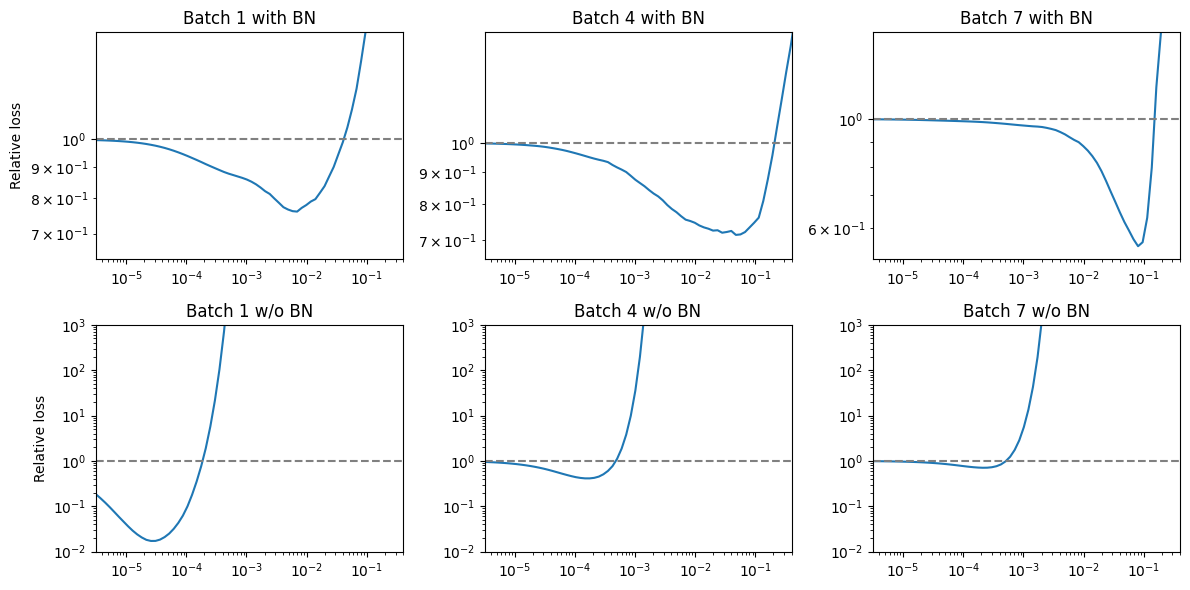

In [65]:
#| code-summary: Plotting the results
f, axs = plt.subplots(2, 3, figsize = (12, 6))

for (batch, rel_losses), ax in zip(with_bn.items(), axs[0]):
    ax.plot(lrs, rel_losses)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(0, 1.5)
    ax.set_xlim(10**-5.5, 0.4)
    ax.set_title(f'Batch {batch} with BN')
    ax.axhline(1, color = 'grey', linestyle = '--')

for (batch, rel_losses), ax in zip(without_bn.items(), axs[1]):
    ax.plot(lrs[:len(rel_losses)], rel_losses)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(10**-2, 10**3)
    ax.set_xlim(10**-5.5, 0.4)
    ax.set_title(f'Batch {batch} w/o BN')
    ax.axhline(1, color = 'grey', linestyle = '--')

axs[0, 0].set_ylabel('Relative loss')
axs[1, 0].set_ylabel('Relative loss')
f.tight_layout()

Although we get roughly different scales, we observe that unnormalized networks reduce the loss only with small steps while normalized ones can improve with a much larger range, as in the paper. 

### Fig 5

Figures 5 and 6 explore the behavior of networks at initialization. Figure 5 displays the mean and variances of channels in the network as a function of depth at initialization. We initialize $10$ networks and use forward hooks to log their channel mean and standard deviations.

In [45]:
#| code-summary: Log activation stats

df = []

def log_activation_stats(layer_name, key):
    def hook(module, input, output):
        with torch.no_grad():
            df.append({
                'bn': key,
                'layer': layer_name,
                'mean': output[:, 0, :, :].mean().abs().item(),
                'std': output[:, 0, :, :].std().abs().item()
            })
    return hook


for _ in range(10):

    for bn in [True, False]:

        model = models.resnet101(num_classes = 10)
        model.to(device)
        if not bn: disable_bn(model)
        model.apply(init_net)

        # Layers to log activations from
        log_layers = [] # (n, name, layer)
        n = 1
        for name, layer in model.named_modules():
            if 'conv' in name:
                n += 1
                if n in list(range(5, 101 + 12, 12)):
                    log_layers.append((n, name, layer))

        for n, _, layer in log_layers: layer.register_forward_hook(log_activation_stats(n, str(bn)))
        for images, _ in val_loader: model(images.to(device))

df = pd.DataFrame(df)

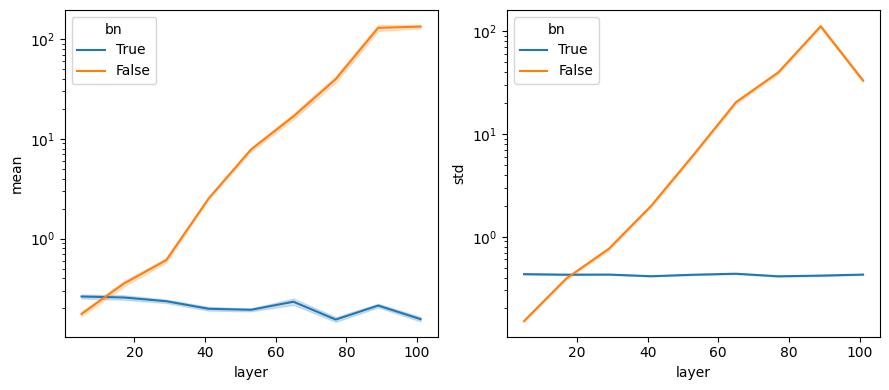

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4))

sns.lineplot(data = df, x = 'layer', y = 'mean', hue = 'bn', ax = ax1)
ax1.set_yscale('log')

sns.lineplot(data = df, x = 'layer', y = 'std', hue = 'bn', ax = ax2)
ax2.set_yscale('log')

f.tight_layout()

We observe, consistent with the findings in the paper, that activation means and standard deviations increase almost exponentially in non-normalized networks, whereas they remain nearly constant in normalized networks.

### Fig 6

The large activations in the final layers for unnormalized networks in the previous figure make us suspect that networks are biased towards a class. The authors investigate whether this is the case by looking at the gradients in the final (output) layer across images in a mini-batch and classes.

Note: Don't confuse this with the last fully connected layer of the network. We are looking at the gradients of the output logits themselves. We need to use `retain_grad` on the output (non-leaf node) to calculate its gradient on the backward pass.

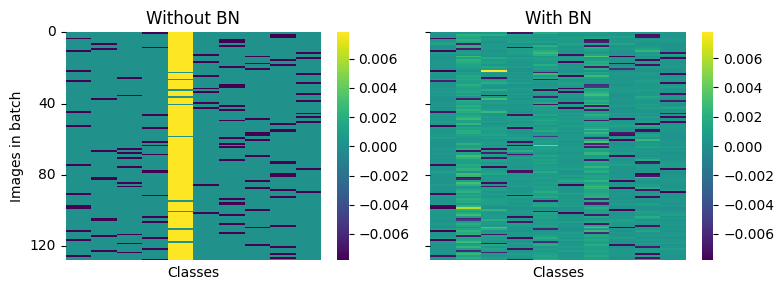

In [69]:
#| code-summary: Generate heatmaps

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3), sharey = True, sharex = True)

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

for bn, ax in zip([False, True], [ax1, ax2]):

    model = models.resnet101(num_classes = 10)
    model.to(device)
    if not bn: disable_bn(model)
    model.apply(init_net)

    out = model(images)
    out.retain_grad()
    loss = nn.CrossEntropyLoss()(out, labels)
    loss.backward()

    ax = sns.heatmap(out.grad.cpu().detach().numpy(), cmap = 'viridis', ax = ax)
    ax.set_xticks([]); ax.set_yticks([0, 40, 80, 120]); ax.set_yticklabels([0, 40, 80, 120])
    ax.set_xlabel('Classes')
    ax.set_ylabel('Images in batch' if not bn else '')
    ax.set_title('With BN' if bn else 'Without BN')

f.tight_layout()

And basically observe the same results as the paper:

>"A yellow entry indicates that the gradient is positive, and the step along the
negative gradient would decrease the prediction strength of this class for this particular image. A
dark blue entry indicates a negative gradient, indicating that this particular class prediction should
be strengthened. Each row contains one dark blue entry, which corresponds to the true class of this
particular image (as initially all predictions are arbitrary). A striking observation is the distinctly
yellow column in the left heatmap (network without BN). This indicates that after initialization the
network tends to almost always predict the same (typically wrong) class, which is then corrected
with a strong gradient update. In contrast, the network with BN does not exhibit the same behavior,
instead positive gradients are distributed throughout all classes."

Running the above code multiple times, however, sometimes results in two or three yellow columns. We think this is because different mini-batches behave slightly differently or due to initialization randomness. Below, we log and average the gradients for a whole epoch and find much more consistent behavior.

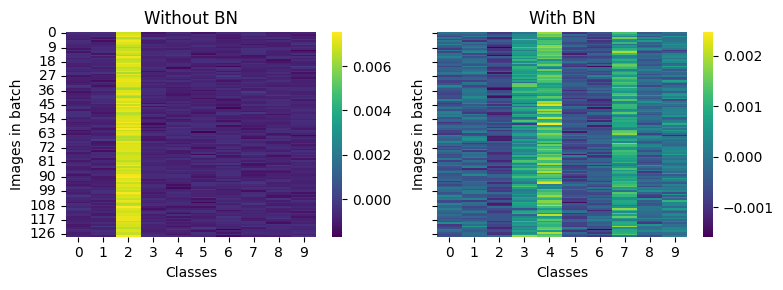

In [370]:
def fig6(init_func = init_net):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 3), sharex = True, sharey = True)

    for bn, ax in zip([False, True], [ax1, ax2]):

        model = models.resnet101(num_classes = 10)
        model.to(device)
        if not bn: disable_bn(model)
        model.apply(init_func)

        avg_grad = torch.zeros((128, 10), device = device)

        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            out = model(images)
            out.retain_grad()
            loss = nn.CrossEntropyLoss()(out, labels)
            loss.backward()
            if out.grad.shape == avg_grad.shape: avg_grad += out.grad
        
        avg_grad /= len(val_loader)

        ax = sns.heatmap(avg_grad.cpu().detach().numpy(), cmap = 'viridis', ax = ax)
        ax.set_xlabel('Classes')
        ax.set_ylabel('Images in batch')
        ax.set_title('With BN' if bn else 'Without BN')

    f.tight_layout()

fig6()

And that's about it.

### What I learned / practiced

I gained a better understanding and intuition of why Batch Normalization (BN) works. More importantly, I got comfortable with PyTorch and debugging training, etc.

Pytorch specific:

- Basics of image augmentation: basically use [transforms](https://pytorch.org/vision/stable/transforms.html) and compose them.
- Learning rate schedulers: they exist, are really useful, and pytorch has a [good assortment of them](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/).
- `state_dict` preserves optimizer's param groups and args (learning rates, etc.) but also momentum buffers.
- [hooks](https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/) as useful debugging and visualization tools.
- `retain_grad` is required to get gradients of non-leaf nodes like the output logits.

For the large training runs, I also experimented with [jarvislabs.ai](https://jarvislabs.ai) as a provider. In-browser notebooks and VS Code, and direct SSH/FTP access were pretty nice. I could not work out funkiness with VS Code remote windows. Used

```bash
nohup jupyter nbconvert --execute --to notebook --inplace --allow-errors main.ipynb &
```

to run the notebook, write results, and be able to close the Jupyter / VS Code tab.